# Project: Nonlinear Elliptic Problem POD vs PINNs

Let us consider the two-dimensional spatial domain $\Omega = [0, 1]^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0,\mu_1) \in P = [0.1,1]^2$, find $u(\mu)$ such that

$-\Delta u(\mu)+\frac{\mu_0}{\mu_1}(e^{\mu_1 u(\mu)}-1) = g(x;\mu)$,

with homogeneous Dirichlet boundary conditions and the source term defined as 

$g(x;\mu) = 100\sin(2\pi x_0)\cos(2\pi x_1) \ \ \ \forall x = (x_0,x_1) \in \Omega$.

In particular, we will solve the problem by means of POD-Galerkin method over a finite element full order model and then with a parametric PINN. We want to compare the two approaches in terms of computational costs and accuracy with respect to the full order model.

### Import libraries

In [1]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt

### Initialize

In [2]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [3]:

def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Progetto_b(numPoints, points):
	values_b = mu[0]/mu[1]*np.ones(numPoints, order='F')
	return values_b.ctypes.data

def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu[0]*np.exp(mu[1]*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu[0]/mu[1]*(np.exp(mu[1]*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data

def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
    return values_g.ctypes.data

def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu[0]/mu[1]*(np.exp(mu[1]*vecu)-1)
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

In [4]:
#values_g = np.zeros(numPoints)
#for i in range(numPoints):
#values_g[i] = 100*mt.sin(2*mt.pi*matPoints[0,i])*mt.cos(2*mt.pi*matPoints[1,i])

### Definition of Simulation Parameters

Geometry parameters

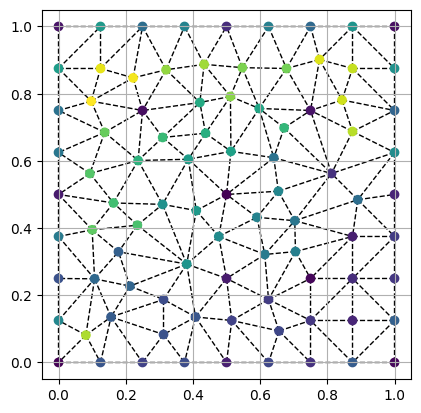

(3, 57)


In [5]:
meshSize = 0.01
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotDofs(mesh,dofs,strongs)
print(dofs.shape)

Newton parameters

In [6]:
residual_norm = 1.0
solution_norm = 1.0
newton_tol = 1.0e-6
max_iterations = 10
num_iteration = 1

### Newton Algorithm

In [7]:
mu = [0.8, 0.4]
#def newton_algorithm(esatta):
u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
print("HIGH FIDELITY SOLUTION")
#if esatta:
#else:
while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k, u_strong, problemData, lib)

    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
    
    du = gedim.LUSolver(stiffness + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k = u_k + du

    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    
    num_iteration = num_iteration + 1

#return u_k, u_strong

HIGH FIDELITY SOLUTION
dofs h iteration max_iteration
57 2.0647876100132428e-01 1 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 2 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 3 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 4 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 5 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 6 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 7 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 8 10
dofs h iteration max_iteration
57 2.0647876100132428e-01 9 10


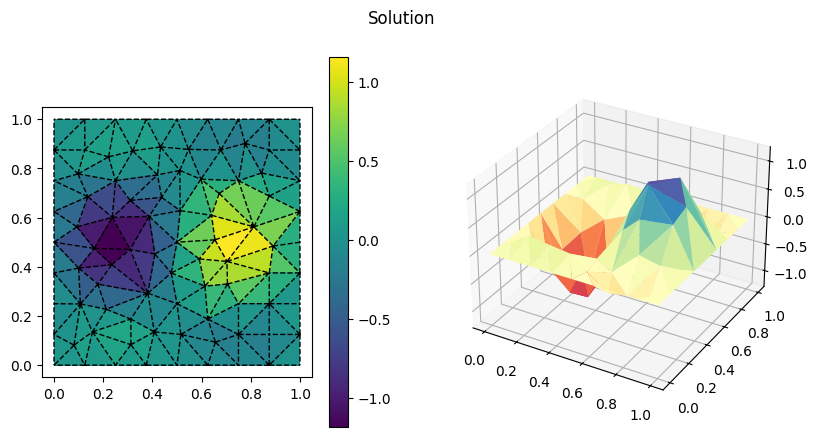

In [8]:
#[u_esatta, u_strong_esatta] = newton_algorithm(esatta = True)
#gedim.PlotSolution(mesh, dofs, strongs, u_esatta, u_strong_esatta)
#gedim.ExportSolution(Progetto_exactSolution, u_esatta, u_strong_esatta, lib)

#[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_esatta, u_strong_esatta, lib)
#gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [9]:
#[u_progetto, u_strong_progetto] = newton_algorithm(esatta = False)
#gedim.PlotSolution(mesh, dofs, strongs, u_progetto, u_strong_progetto)
#gedim.ExportSolution(Progetto_exactSolution, u_progetto, u_strong_progetto, lib)

#[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_progetto, u_strong_progetto, lib)
#gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

# POD

## Offline phase 

In [10]:
### define the training set

snapshot_num = 300 
mu0_range = [0.1, 1.]
mu1_range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0_range, mu1_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))
print(P.shape[0])

2


In [11]:
#### snapshot matrix creation
snapshot_matrix = []

tol = 1. -1e-7
N_max = 10

for mu in training_set:
    num_iteration = 1
    u_k_snap = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong_snap = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness_snap, stiffnessStrong_snap] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g_snap = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    while num_iteration < max_iterations: 
        [reaction_snap, reactionStrong_snap] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_snap, u_strong_snap, problemData, lib)
    
        forcingTerm_v_snap = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_snap, u_strong_snap, problemData, lib)
        forcingTerm_der_v_snap = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_snap, u_strong_snap, problemData, lib)
        
        du_snap = gedim.LUSolver(stiffness_snap + reaction_snap, \
                forcingTerm_g_snap - forcingTerm_v_snap - forcingTerm_der_v_snap, \
                lib)
        u_k_snap = u_k_snap + du_snap
        
        #print("dofs", "h", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
        
        num_iteration = num_iteration + 1
    snapshot = u_k_snap
    snapshot_matrix.append(np.copy(snapshot))
    
snapshot_matrix = np.array(snapshot_matrix) 
#print(snapshot_matrix.shape)# 100 valori diversi dei parametri (M=100), su ogni riga ho la soluzione per un determinato parametro valutata nei 713 nodi interni
#print(snapshot_matrix)

In [12]:
### covariance matrix
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
inner_product = stiffness

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 


L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)
#print(relative_retained_energy)

The reduced dimension is 3


In [13]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) 
  
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (57, 3)


# Online phase

In [14]:
mu = [0.8, 0.4]

u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
u_k_red = np.zeros(N, order='F')

num_iteration = 1
# tutto ciò che non dipende da u_k lo mettiamo fuori dal while
[stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)

while num_iteration < max_iterations: 
    [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
    #reaction = mu[0]*reaction_red
    forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
    forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)

    reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
    reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions
    reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
    
    reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
    reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red

    du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
            reduced_g - reduced_v - reduced_der_v, \
            lib)
    u_k_red = u_k_red + du_red

    u_k_proj = basis_functions @ u_k_red
    du_proj = basis_functions @ du_red

    '''du_normL2 = gedim.ComputeErrorL2(Zeros, du_proj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
    u_normL2 = gedim.ComputeErrorL2(Zeros, u_k_proj, u_strong, lib) # we aim it is zero, so we pass to it the zero function
    u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k_proj, u_strong, lib)
    solution_norm_proj = u_normL2;
    residual_norm_proj = du_normL2;

    print("dofs", "h", "residual", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residual_norm_proj / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))'''
        
    num_iteration = num_iteration + 1



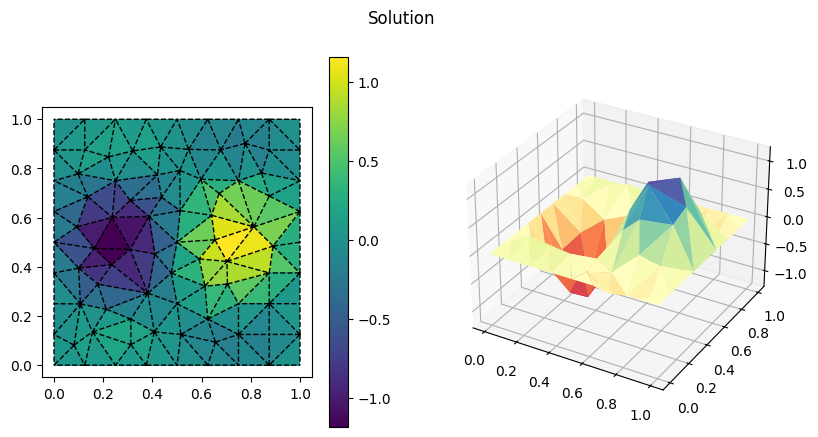

In [15]:
gedim.PlotSolution(mesh, dofs, strongs, u_k_proj, u_strong_red)

#gedim.ExportSolution(Progetto_exactSolution, u_k_proj, u_strong_red, lib)
#[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k_proj, u_strong_red, lib)
#gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [19]:
### compute error

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    num_iteration = 1
    u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
    
        num_iteration = num_iteration + 1
    
    u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
    u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
    u_k_red = np.zeros(N, order='F')

    num_iteration = 1
    [stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    
    while num_iteration < max_iterations: 
        [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
        #reaction = mu[0]*reaction_red
        
        forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)
        
        reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
        reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions
        reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
        
        reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
        reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red
        du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
                reduced_g - reduced_v - reduced_der_v, \
                lib)
        u_k_red = u_k_red + du_red
    
        u_k_proj = basis_functions @ u_k_red
        du_proj = basis_functions @ du_red
        
        num_iteration = num_iteration + 1
      
    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

Computing error and speedup analysis


In [20]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

#print("avarege relative error = ", np.mean(rel_err) )
#print("avarege absolute error = ", np.mean(abs_err) )

Average relative error: 2.2609110535109508e-05
Average absolute error: 9.638551706010515e-05


## PINN

In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable

seed = 35
np.random.seed(seed)
torch.manual_seed(seed)

Let us define the Neural Network.

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        #self.hidden_layer5 = nn.Linear(7,7)
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1):
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1)
        layer1_out = torch.sigmoid(self.input_layer(input)) #
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        #layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        output = self.output_layer(layer5_out)
        return output

Model

In [23]:
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [24]:
## PDE as loss function
def R(x_0,x_1,mu_0,mu_1,net):
    u = net(x_0,x_1,mu_0,mu_1) # the dependent variable u is given by the network based on independent variables x_0,x_1,mu_0,mu_1
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0]
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0]

    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0]
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0]

    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))

    pde = -u_xx + mu_0/mu_1*(torch.exp(mu_1*u)-1) - g
    return pde

In [25]:
dim = 200
x0 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))
x1 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))

all_zeros = np.zeros((dim,1))
all_ones = np.ones((dim,1))

lh = np.concatenate([x0, all_ones, x0, all_zeros],axis=0)
rl = np.concatenate([all_zeros, x1, all_ones, x1],axis=0)

u_bc = np.zeros((dim*4,1))

# training set relative to mu
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))

# training set relative to interior points
x0_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1)) 
x1_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1))

gamma = 4000
iterations = 5000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x0_bc = Variable(torch.from_numpy(lh).float(), requires_grad=False)
    pt_x1_bc = Variable(torch.from_numpy(rl).float(), requires_grad=False)

    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    tensor_mu_0 = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
    tensor_mu_1 = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
    net_bc_out = net(pt_x0_bc, pt_x1_bc, tensor_mu_0, tensor_mu_1) # output of u(x0,x1,mu_0,mu_1)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE        
    all_zeros = np.zeros((dim*4,1))
    
    pt_x0_collocation = Variable(torch.from_numpy(x0_collocation).float(), requires_grad=True)
    pt_x1_collocation = Variable(torch.from_numpy(x1_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = R(pt_x0_collocation, pt_x1_collocation, tensor_mu_0, tensor_mu_1, net) # output of R(x_0,x_1,mu_0,mu_1,net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = gamma*mse_u + mse_f
    
    loss.backward() 
    optimizer.step()
    
    with torch.autograd.no_grad():
        if epoch % 500 == 0:
            print(epoch,"Loss:",loss.item())


0 Loss: 2455.600341796875
500 Loss: 2454.379150390625
1000 Loss: 1248.6328125
1500 Loss: 152.24868774414062
2000 Loss: 108.04701232910156
2500 Loss: 64.61590576171875
3000 Loss: 45.98280715942383
3500 Loss: 37.0146484375
4000 Loss: 30.618940353393555
4500 Loss: 25.660802841186523


## Test

In [27]:
meshSize = 0.01
order = 1
#all the boundary conditions are homogenous dirichlet boundary conditions so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
#[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

# BoundaryConditionsType=2 means Dirichlet conditions
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# boundary points
x0_bc = strongs[0].reshape(-1,1)
x1_bc = strongs[1].reshape(-1,1)

# transform to tensor
x_0_bc_tensor = Variable(torch.from_numpy(x0_bc).float(), requires_grad=False)
x_1_bc_tensor = Variable(torch.from_numpy(x1_bc).float(), requires_grad=False)

# interior points
x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)

# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu_0 = 0.8
mu_1 = 0.4
mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)

mu_0_bc_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
mu_1_bc_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)

## Prediction

In [28]:
all_zeros = np.zeros((x_1_tensor.shape[0],1))
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)

u_x0 = torch.autograd.grad(u_pred.sum(), x_0_tensor, create_graph=True)[0] #derivative of u over x_0
u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0_tensor, create_graph=True)[0]


u_x1 = torch.autograd.grad(u_pred.sum(), x_1_tensor, create_graph=True)[0] #derivative of u over x_1
u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1_tensor, create_graph=True)[0] #second derivative of u over x_1

u_xx = u_x0x0 + u_x1x1

g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0_tensor.detach().numpy()) * np.cos(2 * np.pi * x_1_tensor.detach().numpy()))

f_nolin = mu_0_tensor / mu_1_tensor * (torch.exp(mu_1_tensor * u_pred)-1)

pde = - u_xx + f_nolin - g

mse_f = mse_cost_function(pde, pt_all_zeros)


In [29]:
u_pred = u_pred.data.cpu().numpy().astype(np.float64)
u_pred = u_pred.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

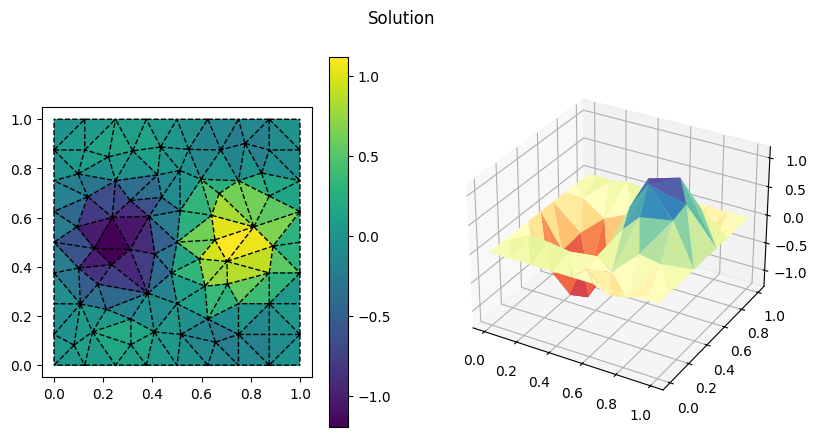

In [30]:
gedim.PlotSolution(mesh, dofs, strongs, u_pred, u_strong)

## Error

In [33]:
### compute error

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    num_iteration = 1
    u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    while num_iteration < max_iterations: #and residual_norm>newton_tol*solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_b, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
    
        num_iteration = num_iteration + 1
    u_k_tensor = Variable(torch.from_numpy(u_k).float(), requires_grad=True)
    
    mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    
    mu_0_bc_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
    mu_1_bc_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
    u_predicted = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)
    
    error_vector = u_k_tensor - u_predicted
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)

In [ ]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

# POD-NN

In [31]:
import torch.nn.functional as F

mu_dim = P.shape[0]
basis_dim = N 
input_dim = mu_dim # equal to the dim of parameter space
output_dim = basis_dim # basis number chosen before
nodes = 30 # number of nodes inside

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, output_dim) # 4 layers before the output
        self.tanh = nn.Tanh() #activation function
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
        return x

In [32]:
seed_num = 31
torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1.

In [33]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
y_train = []

#given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)

for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)

In [34]:
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
  #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step() # update the lr??
  if epoch % 200 == 199:
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

epoch 199 loss 0.5072818994522095 lr 0.001
epoch 399 loss 0.019608449190855026 lr 0.001
epoch 599 loss 0.006210428662598133 lr 0.001
epoch 799 loss 0.002026838716119528 lr 0.001
epoch 999 loss 0.0009792611235752702 lr 0.001
epoch 1199 loss 0.0005636425921693444 lr 0.001
epoch 1399 loss 0.0003700810484588146 lr 0.001
epoch 1599 loss 0.0002737678005360067 lr 0.001
epoch 1799 loss 0.00021802751871291548 lr 0.001
epoch 1999 loss 0.00018151126278098673 lr 0.001
epoch 2199 loss 0.0001554281625431031 lr 0.001
epoch 2399 loss 0.0001354632549919188 lr 0.001
epoch 2599 loss 0.0001192953423014842 lr 0.001
epoch 2799 loss 0.00010563780961092561 lr 0.001
epoch 2999 loss 9.385825978824869e-05 lr 0.001
epoch 3199 loss 8.360273204743862e-05 lr 0.001
epoch 3399 loss 7.478735642507672e-05 lr 0.001
epoch 3599 loss 7.884562364779413e-05 lr 0.001
epoch 3799 loss 5.9442441852297634e-05 lr 0.001
epoch 3999 loss 6.226229743333533e-05 lr 0.001
epoch 4199 loss 4.7525583795504645e-05 lr 0.001
epoch 4399 loss 4.9

In [35]:
#we compute the solution

x_test = [[.8, .4]] 
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0] #we transform the tensor in an array form

print(reduced_solution)

[-2.2909284   1.4790999   0.48717245]


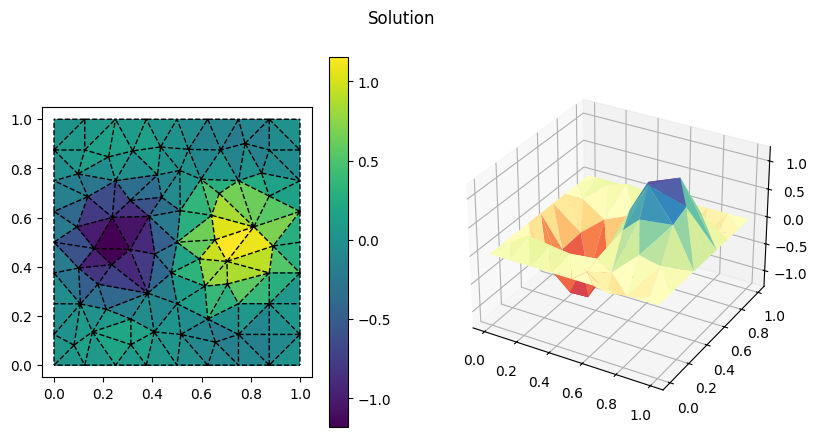

In [36]:
nn_proj_reduced_solution = basis_functions @ reduced_solution # we want to see the solution in the high fidelity setting
mu = x_test[0]

u_strong = np.zeros(problemData['NumberStrongs'], order='F') 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, u_strong)